# Sentiment Classification of Product Reviews

In [27]:
import os
import kagglehub
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud



In [28]:
os.environ["SKLEARN_NO_REPR_HTML"] = "1"

In [29]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")
print("Path to dataset files:", path)
# Afficher les fichiers présents dans le dossier
print("Fichiers présents dans le dataset :")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))
# Charger les deux fichiers
amazon_fine_food_reviews = pd.read_csv(os.path.join(path, "Reviews.csv"))


Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\snap\amazon-fine-food-reviews\versions\2
Fichiers présents dans le dataset :
C:\Users\User\.cache\kagglehub\datasets\snap\amazon-fine-food-reviews\versions\2\database.sqlite
C:\Users\User\.cache\kagglehub\datasets\snap\amazon-fine-food-reviews\versions\2\hashes.txt
C:\Users\User\.cache\kagglehub\datasets\snap\amazon-fine-food-reviews\versions\2\Reviews.csv


## Étape 1 : Chargement et aperçu des données

In [31]:
print("\nInfos:")
amazon_fine_food_reviews.info()


Infos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [32]:
print("\nStatistiques :")
print(amazon_fine_food_reviews.describe(include='all'))


Statistiques :
                   Id   ProductId          UserId       ProfileName  \
count   568454.000000      568454          568454            568428   
unique            NaN       74258          256059            218415   
top               NaN  B007JFMH8M  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
freq              NaN         913             448               451   
mean    284227.500000         NaN             NaN               NaN   
std     164098.679298         NaN             NaN               NaN   
min          1.000000         NaN             NaN               NaN   
25%     142114.250000         NaN             NaN               NaN   
50%     284227.500000         NaN             NaN               NaN   
75%     426340.750000         NaN             NaN               NaN   
max     568454.000000         NaN             NaN               NaN   

        HelpfulnessNumerator  HelpfulnessDenominator          Score  \
count          568454.000000            568454.00000  568454

In [33]:
amazon_fine_food_reviews_filtered = amazon_fine_food_reviews[['Text', 'Score']]  # Garde uniquement les colonnes utiles
amazon_fine_food_reviews_filtered.dropna(inplace=True)
# Supprimer les lignes avec Text vide ou null
amazon_fine_food_reviews_filtered.dropna(subset=['Text'], inplace=True)
amazon_fine_food_reviews_filtered = amazon_fine_food_reviews_filtered[amazon_fine_food_reviews_filtered['Text'].str.strip() != '']

# Retirer les doublons
amazon_fine_food_reviews_filtered.drop_duplicates(subset=['Text'], inplace=True)

# Forcer le type str
amazon_fine_food_reviews_filtered['Text'] = amazon_fine_food_reviews_filtered['Text'].astype(str)
amazon_fine_food_reviews_filtered

C:\Users\User\AppData\Local\Temp\ipykernel_10688\3215037876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_fine_food_reviews_filtered.dropna(inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_10688\3215037876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_fine_food_reviews_filtered.dropna(subset=['Text'], inplace=True)


,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
...,...,...
568449,Great for sesame chicken..this is a good if no...,5
568450,I'm disappointed with the flavor. The chocolat...,2
568451,"These stars are small, so you can give 10-15 o...",5
568452,These are the BEST treats for training and rew...,5


## Étape 2 : Création de labels
On va transformer les scores en étiquettes :

In [34]:
def label_sentiment(score):
    if score <= 2:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

amazon_fine_food_reviews_filtered['Sentiment'] = amazon_fine_food_reviews_filtered['Score'].apply(label_sentiment)
amazon_fine_food_reviews_filtered['Sentiment'].value_counts()

Sentiment
Positive    306758
Negative     57067
Neutral      29754
Name: count, dtype: int64

## Étape 3 : Nettoyage du texte

In [35]:
print(amazon_fine_food_reviews_filtered.columns)
print(type(amazon_fine_food_reviews_filtered))


Index(['Text', 'Score', 'Sentiment'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


In [36]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    try:
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
        return " ".join(tokens)
    except Exception as e:
        print(f"Erreur de traitement sur : {text[:100]}... — {e}")
        return ""

amazon_fine_food_reviews_filtered['Clean_Text'] = amazon_fine_food_reviews_filtered['Text'].apply(preprocess)


In [37]:
print("stopwords sample:", list(stop_words)[:10])
print("lemmatizer test:", lemmatizer.lemmatize("running"))  # ➜ "running" → "running" (mot de base)
print("lemmatizer test (v):", lemmatizer.lemmatize("running", pos='v'))  # ➜ "run"


stopwords sample: ['don', 'which', "couldn't", "wouldn't", 'up', 'by', 'i', 'can', 'did', 'doing']
lemmatizer test: running
lemmatizer test (v): run


In [38]:
amazon_fine_food_reviews_filtered

,Text,Score,Sentiment,Clean_Text
0,I have bought several of the Vitality canned d...,5,Positive,bought several vitality canned dog food produc...
1,Product arrived labeled as Jumbo Salted Peanut...,1,Negative,product arrived labeled jumbo salted peanutsth...
2,This is a confection that has been around a fe...,4,Positive,confection around century light pillowy citrus...
3,If you are looking for the secret ingredient i...,2,Negative,looking secret ingredient robitussin believe f...
4,Great taffy at a great price. There was a wid...,5,Positive,great taffy great price wide assortment yummy ...
...,...,...,...,...
568449,Great for sesame chicken..this is a good if no...,5,Positive,great sesame chickenthis good better resturant...
568450,I'm disappointed with the flavor. The chocolat...,2,Negative,disappointed flavor chocolate note especially ...
568451,"These stars are small, so you can give 10-15 o...",5,Positive,star small give one training session tried tra...
568452,These are the BEST treats for training and rew...,5,Positive,best treat training rewarding dog good groomin...


## Étape 4 : Vectorisation et séparation des données

Objectifs :
Transformer le texte nettoyé (Clean_Text) en vecteurs numériques.

Préparer les données pour l’entraînement d’un modèle ML.

In [39]:
# Initialiser le vectoriseur TF-IDF
vectorizer_5000 = TfidfVectorizer(max_features=5000)

# Appliquer sur les textes nettoyés
X = vectorizer_5000.fit_transform(amazon_fine_food_reviews_filtered['Clean_Text'])

# Cible : le sentiment (déjà construit auparavant, ex: 'Positive', 'Negative', 'Neutral')
y = amazon_fine_food_reviews_filtered['Sentiment']

# Séparer en jeu d'entraînement et de test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (314863, 5000), Test size: (78716, 5000)


## Étape 5 : Entraînement du modèle de classification

[[ 7383   452  3578]
 [ 1366   815  3770]
 [ 1481   565 59306]]
              precision    recall  f1-score   support

    Negative       0.72      0.65      0.68     11413
     Neutral       0.44      0.14      0.21      5951
    Positive       0.89      0.97      0.93     61352

    accuracy                           0.86     78716
   macro avg       0.69      0.58      0.61     78716
weighted avg       0.83      0.86      0.84     78716



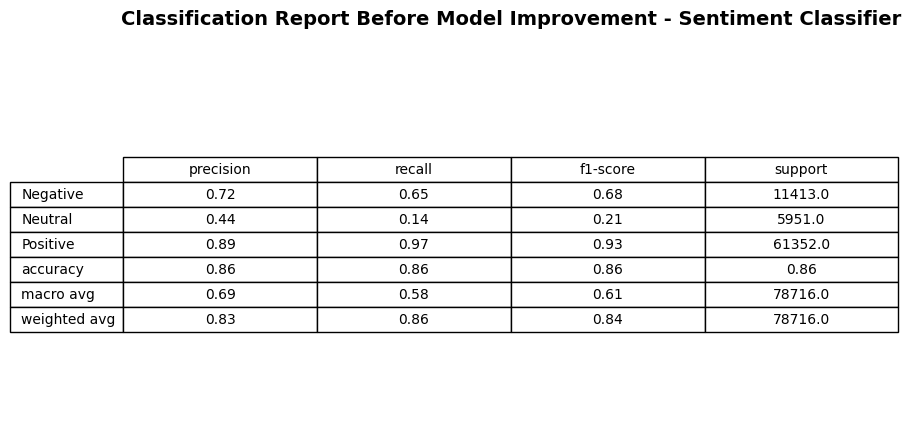

In [40]:
# Initialisation et entraînement
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# --- Génère le report comme dictionnaire ---
report_dict = classification_report(y_test, y_pred, output_dict=True)

# --- Convertir en DataFrame pour plus de contrôle ---
report_df = pd.DataFrame(report_dict).transpose().round(2)

# --- Créer la figure matplotlib ---
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')  # On enlève les axes

# --- Création du tableau en image ---
table = ax.table(
    cellText=report_df.values,
    colLabels=report_df.columns,
    rowLabels=report_df.index,
    loc='center',
    cellLoc='center',
    colLoc='center'
)
table.scale(1, 1.5)  # Ajuste la taille des cellules
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.title("Classification Report Before Model Improvement - Sentiment Classifier", fontsize=14, weight='bold', pad=20)

# --- Sauvegarde de l'image ---
plt.savefig("classification_report_image_before_model_improvement.png", bbox_inches='tight')
plt.show()

Constats :

- Très bonne précision sur la classe Positive (F1 ≈ 0.93)

- Faible score F1 sur Neutral (≈ 0.21)

- Classe Neutral mal détectée → déséquilibre

## Étape 6 : Visualisation de la performance du modèle

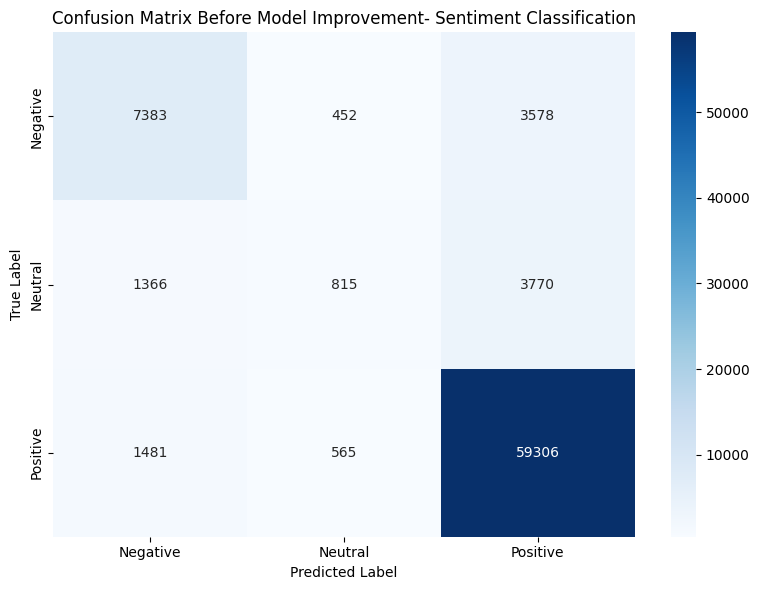

In [41]:
# Redéfinir la matrice
cm = confusion_matrix(y_test, y_pred)
labels = ['Negative', 'Neutral', 'Positive']

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Before Model Improvement- Sentiment Classification')
plt.tight_layout()
plt.show()


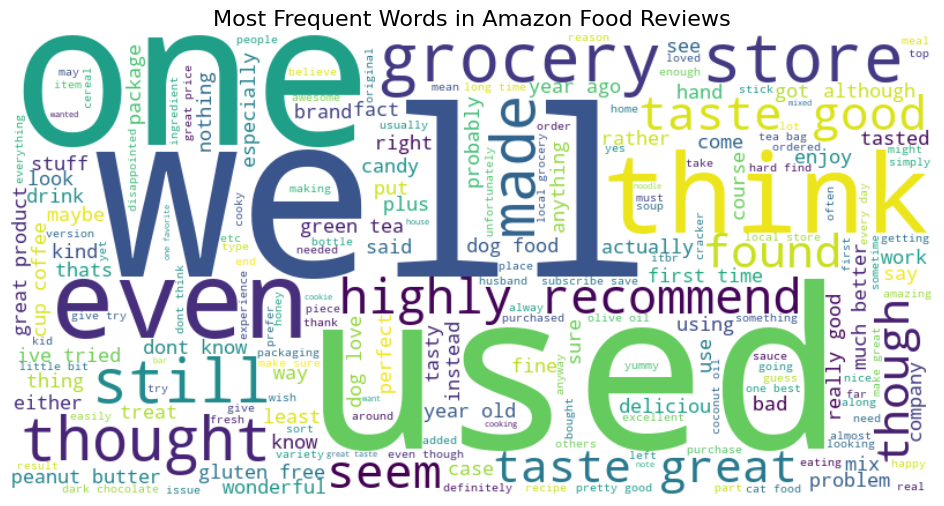

In [42]:
# Join all cleaned text into one string
all_text = " ".join(amazon_fine_food_reviews_filtered["Clean_Text"].dropna())

# Create the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

# Display the WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Amazon Food Reviews", fontsize=16)
plt.show()


## Étape 7 — Améliorer la précision globale du modèle 
Rebalancer les classes via class_weight
Réduction de la dimensionnalité avec max_features
Nettoyage des classes déséquilibrées

In [43]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = vectorizer.fit_transform(amazon_fine_food_reviews_filtered['Clean_Text'])


In [45]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

In [46]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

cross validation

In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
print("F1 macro moyenne :", scores.mean())


F1 macro moyenne : 0.6321283028343432


              precision    recall  f1-score   support

    Negative       0.65      0.72      0.68     11413
     Neutral       0.32      0.35      0.33      5951
    Positive       0.93      0.91      0.92     61352

    accuracy                           0.84     78716
   macro avg       0.63      0.66      0.64     78716
weighted avg       0.84      0.84      0.84     78716



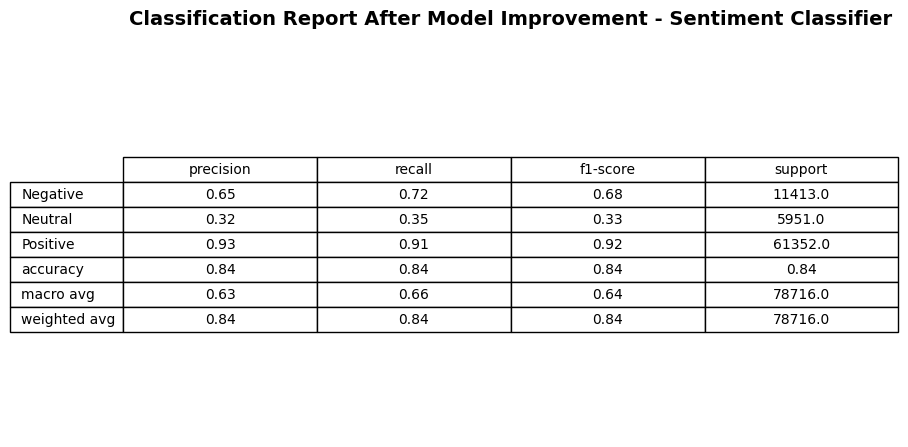

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

# --- Génère le report comme dictionnaire ---
report_dict = classification_report(y_test, y_pred, output_dict=True)

# --- Convertir en DataFrame pour plus de contrôle ---
report_df = pd.DataFrame(report_dict).transpose().round(2)

# --- Créer la figure matplotlib ---
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')  # On enlève les axes

# --- Création du tableau en image ---
table = ax.table(
    cellText=report_df.values,
    colLabels=report_df.columns,
    rowLabels=report_df.index,
    loc='center',
    cellLoc='center',
    colLoc='center'
)
table.scale(1, 1.5)  # Ajuste la taille des cellules
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.title("Classification Report After Model Improvement - Sentiment Classifier", fontsize=14, weight='bold', pad=20)

# --- Sauvegarde de l'image ---
plt.savefig("classification_report_image_after_model_improvement.png", bbox_inches='tight')
plt.show()

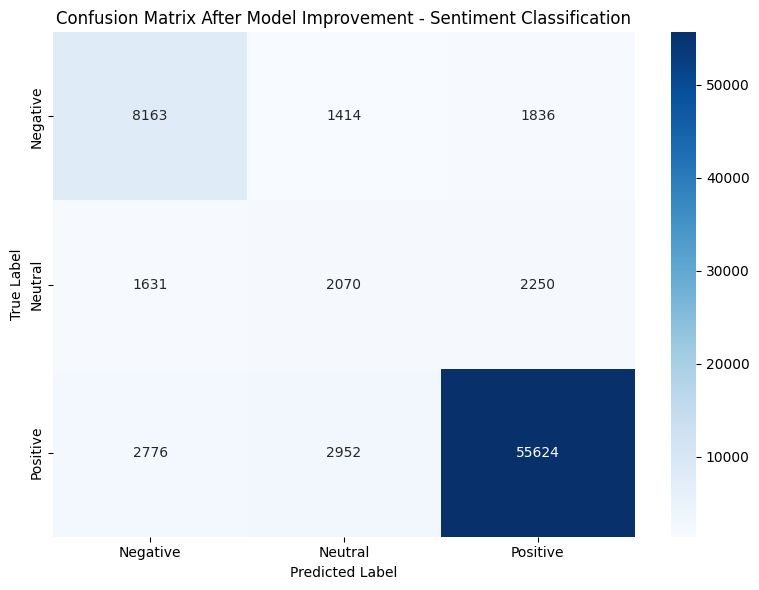

In [49]:
# Redéfinir la matrice
cm = confusion_matrix(y_test, y_pred)
labels = ['Negative', 'Neutral', 'Positive']

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix After Model Improvement - Sentiment Classification')
plt.tight_layout()
plt.show()

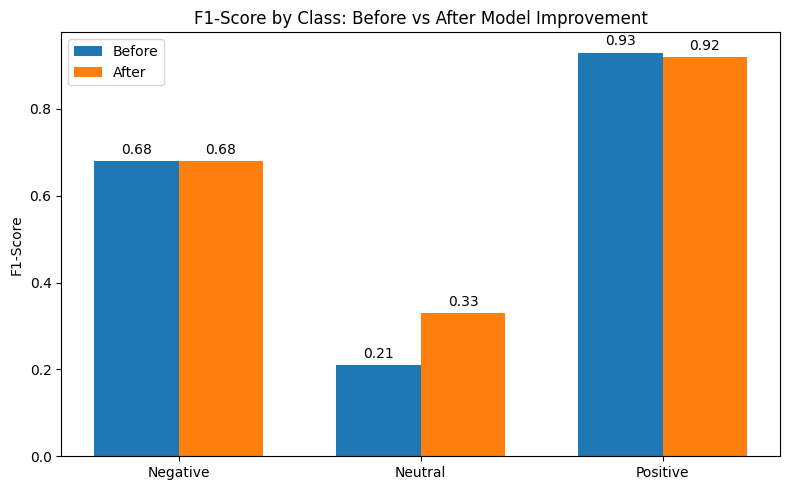

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# valeurs f1-score
f1_before = {'Negative': 0.68, 'Neutral': 0.21, 'Positive': 0.93}
f1_after = {'Negative': 0.68, 'Neutral': 0.33, 'Positive': 0.92}

labels = list(f1_before.keys())
before_scores = [f1_before[label] for label in labels]
after_scores = [f1_after[label] for label in labels]

x = np.arange(len(labels))  # positions
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, before_scores, width, label='Before')
bars2 = ax.bar(x + width/2, after_scores, width, label='After')

# Affichage des scores sur les barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points de décalage
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_ylabel('F1-Score')
ax.set_title('F1-Score by Class: Before vs After Model Improvement')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()


In [51]:

# Recrée un vectorizer limité à 5000 features
vectorizer_5000 = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer_5000.fit_transform(amazon_fine_food_reviews_filtered['Clean_Text'])

# Entraîne ton modèle avec ces données
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X, amazon_fine_food_reviews_filtered['Sentiment'])

LogisticRegression(class_weight='balanced', max_iter=1000)

In [52]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_input(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

# Boucle interactive
while True:
    user_input = input("Enter an English sentence (type 'exit' or 'quit' to stop): ")

    if user_input.lower() in ['exit', 'quit']:
        print("Session ended. Goodbye!")
        break

    cleaned = preprocess_input(user_input)
    vectorized = vectorizer_5000.transform([cleaned])
    prediction = model.predict(vectorized)[0]

    print(f"\nYour sentence: \"{user_input}\"")
    print(f"=> Predicted sentiment: {prediction}\n")



Your sentence: "i love that wine"
=> Predicted sentiment: Positive


Your sentence: "taste funny"
=> Predicted sentiment: Negative


Your sentence: "quite interesting"
=> Predicted sentiment: Neutral


Your sentence: "i won't buy it again"
=> Predicted sentiment: Negative

Session ended. Goodbye!
